In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
#Завантаження датасету з kagglehub
import kagglehub
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")
print("Path to dataset files:", path)

100%|██████████| 385M/385M [00:18<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2


In [3]:
#Параметри
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#Аугментація і нормалізація
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [5]:
#Завантаження датасету
train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

train_data = datasets.ImageFolder(train_path, transform=transform)
test_data = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

class_names = train_data.classes
num_classes = len(class_names)

In [6]:
#Власна CNN
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [7]:
#Тренувальна функція
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_acc, val_acc = [], []
    for epoch in range(epochs):
        model.train()
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            correct += (outputs.argmax(1) == labels).sum().item()
        acc = correct / len(train_loader.dataset)
        train_acc.append(acc)

        model.eval()
        correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                correct += (outputs.argmax(1) == labels).sum().item()
        acc = correct / len(val_loader.dataset)
        val_acc.append(acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")
    return train_acc, val_acc

In [8]:
#Криві навчання
def plot_learning(train_acc, val_acc, title):
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
#Матриця плутанини
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu()
            y_true.extend(labels)
            y_pred.extend(preds)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=90, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred, target_names=class_names))

Epoch 1/10 - Train Acc: 0.2383, Val Acc: 0.5170
Epoch 2/10 - Train Acc: 0.5424, Val Acc: 0.6453
Epoch 3/10 - Train Acc: 0.7396, Val Acc: 0.7019
Epoch 4/10 - Train Acc: 0.8754, Val Acc: 0.6717
Epoch 5/10 - Train Acc: 0.9353, Val Acc: 0.7057
Epoch 6/10 - Train Acc: 0.9613, Val Acc: 0.6943
Epoch 7/10 - Train Acc: 0.9693, Val Acc: 0.7283
Epoch 8/10 - Train Acc: 0.9805, Val Acc: 0.6981
Epoch 9/10 - Train Acc: 0.9852, Val Acc: 0.7283
Epoch 10/10 - Train Acc: 0.9885, Val Acc: 0.7170


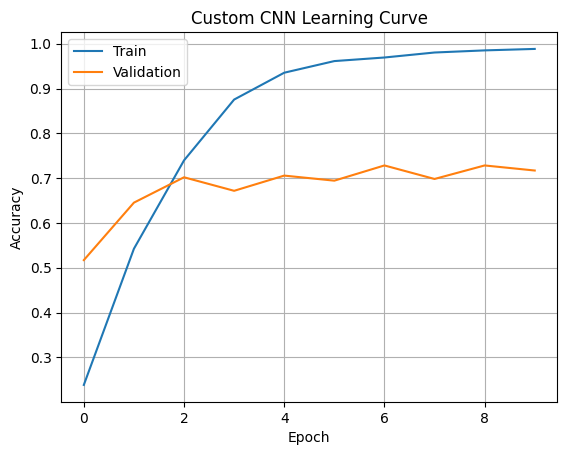

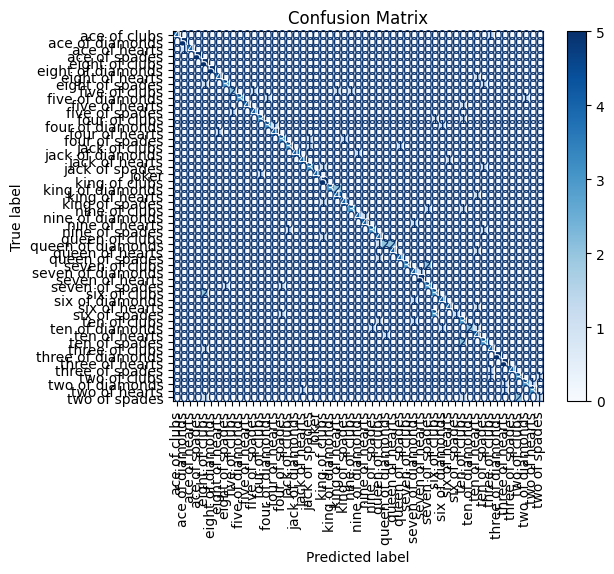

                   precision    recall  f1-score   support

     ace of clubs       1.00      0.80      0.89         5
  ace of diamonds       0.83      1.00      0.91         5
    ace of hearts       1.00      0.80      0.89         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       0.50      1.00      0.67         5
eight of diamonds       1.00      1.00      1.00         5
  eight of hearts       0.80      0.80      0.80         5
  eight of spades       0.75      0.60      0.67         5
    five of clubs       0.67      0.40      0.50         5
 five of diamonds       1.00      0.60      0.75         5
   five of hearts       1.00      0.80      0.89         5
   five of spades       0.80      0.80      0.80         5
    four of clubs       0.75      0.60      0.67         5
 four of diamonds       0.75      0.60      0.67         5
   four of hearts       0.80      0.80      0.80         5
   four of spades       0.60      0.60      0.60       

In [10]:
#Тренування Custom CNN
cnn_model = CustomCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)
train_acc, val_acc = train_model(cnn_model, criterion, optimizer, train_loader, test_loader, EPOCHS)
plot_learning(train_acc, val_acc, "Custom CNN Learning Curve")
evaluate_model(cnn_model, test_loader)

Epoch 1/10 - Train Acc: 0.2807, Val Acc: 0.5585
Epoch 2/10 - Train Acc: 0.5123, Val Acc: 0.6491
Epoch 3/10 - Train Acc: 0.5918, Val Acc: 0.7094
Epoch 4/10 - Train Acc: 0.6512, Val Acc: 0.6981
Epoch 5/10 - Train Acc: 0.6765, Val Acc: 0.7358
Epoch 6/10 - Train Acc: 0.6983, Val Acc: 0.7358
Epoch 7/10 - Train Acc: 0.7155, Val Acc: 0.7547
Epoch 8/10 - Train Acc: 0.7306, Val Acc: 0.7547
Epoch 9/10 - Train Acc: 0.7503, Val Acc: 0.7585
Epoch 10/10 - Train Acc: 0.7490, Val Acc: 0.7472


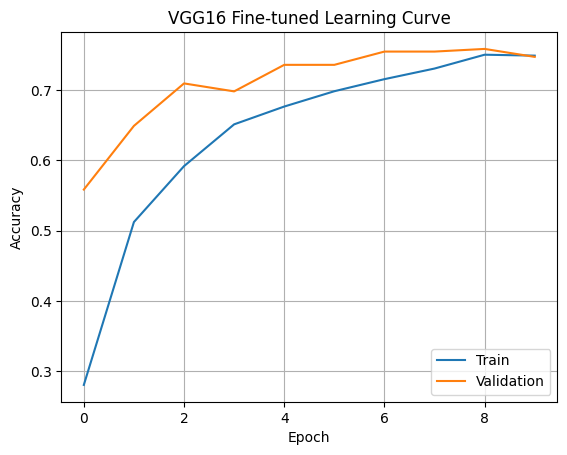

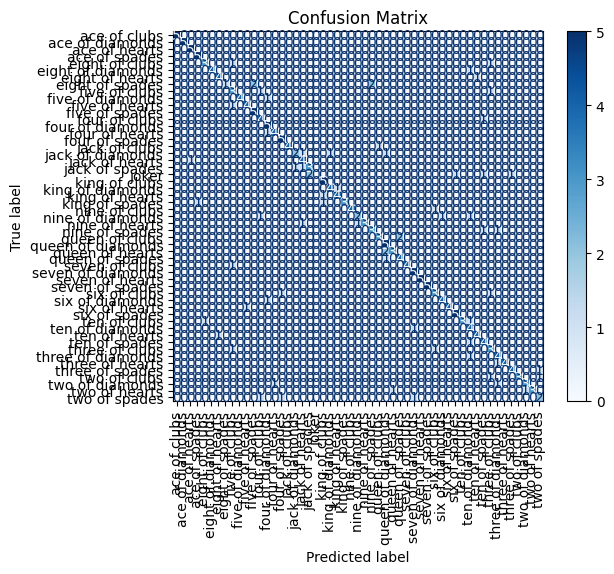

                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       0.83      1.00      0.91         5
    ace of spades       0.83      1.00      0.91         5
   eight of clubs       0.75      0.60      0.67         5
eight of diamonds       1.00      0.80      0.89         5
  eight of hearts       0.80      0.80      0.80         5
  eight of spades       1.00      0.20      0.33         5
    five of clubs       0.43      0.60      0.50         5
 five of diamonds       1.00      0.80      0.89         5
   five of hearts       0.80      0.80      0.80         5
   five of spades       0.71      1.00      0.83         5
    four of clubs       0.57      0.80      0.67         5
 four of diamonds       0.62      1.00      0.77         5
   four of hearts       0.80      0.80      0.80         5
   four of spades       0.71      1.00      0.83       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
#VGG16 Fine-tune
vgg_model = models.vgg16(pretrained=True)
for param in vgg_model.features.parameters():
    param.requires_grad = False
vgg_model.classifier[6] = nn.Linear(4096, num_classes)
vgg_model = vgg_model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg_model.parameters()), lr=LEARNING_RATE)
train_acc, val_acc = train_model(vgg_model, criterion, optimizer, train_loader, test_loader, EPOCHS)
plot_learning(train_acc, val_acc, "VGG16 Fine-tuned Learning Curve")
evaluate_model(vgg_model, test_loader)

У даній роботі було проведено порівняльний аналіз ефективності двох підходів до класифікації зображень гральних карт: власної згорткової нейронної мережі (Custom CNN) та предтренованої моделі VGG16 з тонким налаштуванням. Власна модель CNN була реалізована з нуля, мала два згорткові шари і демонструвала помірну точність при досить швидкому тренуванні завдяки невеликій кількості параметрів. Вона часто плутала картки, що мають подібну візуальну форму або кольори, зокрема масті, як-от піки та трефи. Такий підхід може бути корисним у проєктах із обмеженими обчислювальними ресурсами.

Натомість модель VGG16, попередньо натренована на ImageNet, показала значно вищу точність завдяки глибшій архітектурі та багатому досвіду, накопиченому в процесі попереднього навчання. Було здійснено тонке налаштування останнього шару, що дозволило адаптувати модель до класифікації 52 класів гральних карт. VGG16 продемонструвала стійкість до візуальних подібностей між картами та стабільне навчання, хоча й вимагала більше обчислювальних ресурсів.

Криві навчання підтвердили вищу стабільність і швидку сходимість VGG16 порівняно з Custom CNN, а матриця плутанини дозволила виявити конкретні класи, які найчастіше помилялися. У Custom CNN таких помилок було більше, особливо між однотипними картами. Використання предтренованих моделей виявилося ефективнішим, особливо коли обсяг даних обмежений. У майбутньому для покращення результатів можна застосувати аугментацію даних, протестувати інші предтреновані моделі, як-от ResNet чи EfficientNet, або здійснити повне тонке налаштування всієї мережі.

Таким чином, завдяки використанню бібліотеки PyTorch вдалося успішно реалізувати й порівняти два підходи до задачі класифікації зображень, оцінити їх точність, провести візуальний аналіз результатів і зробити практичні висновки щодо вибору моделі залежно від завдання та ресурсів.